<a href="https://colab.research.google.com/github/supertime1/BERT/blob/main/QA_BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Import Dependencies

In [3]:
%%capture
!pip install tokenizers
!pip install -U tensorflow_text
!pip install -q -U tf-models-official

In [4]:
import os
import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization, bert
import numpy as np
import json
from tokenizers import BertWordPieceTokenizer
import string
import re
tf.get_logger().setLevel('ERROR')
import official.nlp.bert.tokenization

In [5]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [6]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.110.52.122:8470']


In [7]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2571915786495636055
]


In [8]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

False

#2.Helper functions

In [53]:
class Sample:
  def __init__(self, question, context, start_char_idx=None, answer_text=None, all_answers=None):
    self.question = question
    self.context = context
    self.start_char_idx = start_char_idx
    self.answer_text = answer_text
    self.all_answers = all_answers
    self.skip = False
    self.start_token_idx = -1
    self.end_token_idx = -1
  
  def preprocess(self):
  # remove multipe whitespace between characters
    context = " ".join(str(self.context).split())
    question = " ".join(str(self.question).split())
    # tokenize context and question
    tokenized_context = tokenizer.encode(context)
    tokenized_question = tokenizer.encode(question)
    # preprocess answer if this is a validation or training sample
    if self.answer_text:
      answer = " ".join(str(self.answer_text).split())
      # find the end character index
      end_char_idx = self.start_char_idx + len(answer)
      
      # sometimes squad answers are off by a character or two – fix this
      if context[self.start_char_idx-1:end_char_idx-1] == answer:
          self.start_char_idx -= 1
          end_char_idx -= 1
      elif context[self.start_char_idx-2:end_char_idx-2] == answer:
          self.start_char_idx -= 2
          end_char_idx -= 2
      
      # check if end character index is in the context
      if end_char_idx > len(context):
        self.skip = True
        return
      # mark all the character indexes in context that are also in answer
      is_char_in_ans = [0] * len(context)
      for idx in range(self.start_char_idx, end_char_idx):
        is_char_in_ans[idx] = 1
      # find all the tokens that are in the answers
      ans_token_idx = []
      for idx, (start, end) in enumerate(tokenized_context.offsets):
        if sum(is_char_in_ans[start:end]) > 0:
          ans_token_idx.append(idx)
      if len(ans_token_idx) == 0:
        self.skip = True
        return
      # get start and end token indexes
      self.start_token_idx = ans_token_idx[0]
      self.end_token_idx = ans_token_idx[-1]

    # create inputs as usual
    input_ids = tokenized_context.ids + tokenized_question.ids[1:]
    attention_mask = [1] * len(input_ids)
    token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
    padding_length = max_seq_length - len(input_ids)
    # add padding if necessary
    if padding_length > 0:
      input_ids += [0] * padding_length
      attention_mask += [0] * padding_length
      token_type_ids += [0] * padding_length

    elif padding_length < 0:
      self.skip = True
      return

    self.input_word_ids = input_ids
    self.input_type_ids = token_type_ids
    self.input_mask = attention_mask
    self.context_token_to_char = tokenized_context.offsets

In [54]:
def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                if "answers" in qa and qa["answers"] != []:
                    all_answers = [_["text"] for _ in qa["answers"]]
                    for answer in qa['answers']:
                        answer_text = answer["text"]
                        start_char_idx = answer["answer_start"]
                        squad_eg = Sample(question, context, start_char_idx, answer_text, all_answers)
                else:
                    squad_eg = Sample(question, context)
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples

In [55]:
def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_word_ids": [],
        "input_type_ids": [],
        "input_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])
    x = [dataset_dict["input_word_ids"],
         dataset_dict["input_mask"],
         dataset_dict["input_type_ids"]]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

#3.Download a BERT model and fine-tune it

In [12]:
train_path = keras.utils.get_file("train.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json")
eval_path = keras.utils.get_file("eval.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json")
with open(train_path) as f: raw_train_data = json.load(f)
with open(eval_path) as f: raw_eval_data = json.load(f)

4374528/4370528 [==============================] - 0s 0us/step


In [13]:
max_seq_length = 384
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
tokenizer = BertWordPieceTokenizer('bert-base-uncased-vocab.txt')

--2021-01-17 17:15:07--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.100.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.100.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  --.-KB/s    in 0.1s    

2021-01-17 17:15:07 (1.86 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



In [56]:
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")
eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

# tensorflow pipeline
batch_size = 64
#train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#validation = tf.data.Dataset.from_tensor_slices((x_eval, y_eval))
#train_dataset = train.cache()
#train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

130319 training points created.
11873 evaluation points created.


In [73]:
# Check how many training sample that has answer but the start_token_idx is -1
len([i for i in train_squad_examples if i.start_token_idx == -1 and i.answer_text != None and i.skip==False])

0

In [74]:
# Sanity check if all sample in training have/dont have answers
lst = [i for i in range(len(train_squad_examples)) if train_squad_examples[i].all_answers == None and train_squad_examples[i].skip == False]
print(f"There are {len(lst)} samples have no answers.")
lst = [i for i in range(len(train_squad_examples)) if train_squad_examples[i].all_answers != None and train_squad_examples[i].skip == False]
print(f"There are {len(lst)} samples have answers.")

There are 43011 samples have no answers.
There are 85934 samples have answers.


In [81]:
# create model
def create_model():
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    start_logits = tf.keras.layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
    start_logits = tf.keras.layers.Flatten()(start_logits)
    end_logits = tf.keras.layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
    end_logits = tf.keras.layers.Flatten()(end_logits)
    #start_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(start_logits)
    #end_probs = tf.keras.layers.Activation(tf.keras.activations.softmax)(end_logits)
    model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=[start_logits, end_logits])
    
    return model

In [87]:
tf.one_hot(np.array([-1,0,1,2,3]) + 1, depth=5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [88]:
class CustomizedLoss(tf.keras.losses.Loss):
    def compute_loss(self, logits, positions):
        one_hot_positions = tf.one_hot(
            positions, depth=max_seq_length, dtype=tf.float32)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        loss = -tf.reduce_mean(
            tf.reduce_sum(one_hot_positions * log_probs, axis=-1))
        return loss
    
    def call(self, y_true, y_pred):
        start_loss = self.compute_loss(y_pred[0], y_true[0])
        end_loss = self.compute_loss(y_pred[1], y_true[1])
        total_loss = (start_loss + end_loss) / 2.0
        return total_loss

In [89]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
    # setup compile
    #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=CustomizedLoss())
    model.fit(x_train, y_train, epochs=2, batch_size=batch_size, validation_data=(x_eval, y_eval))

Epoch 1/2


ValueError: ignored

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 384)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

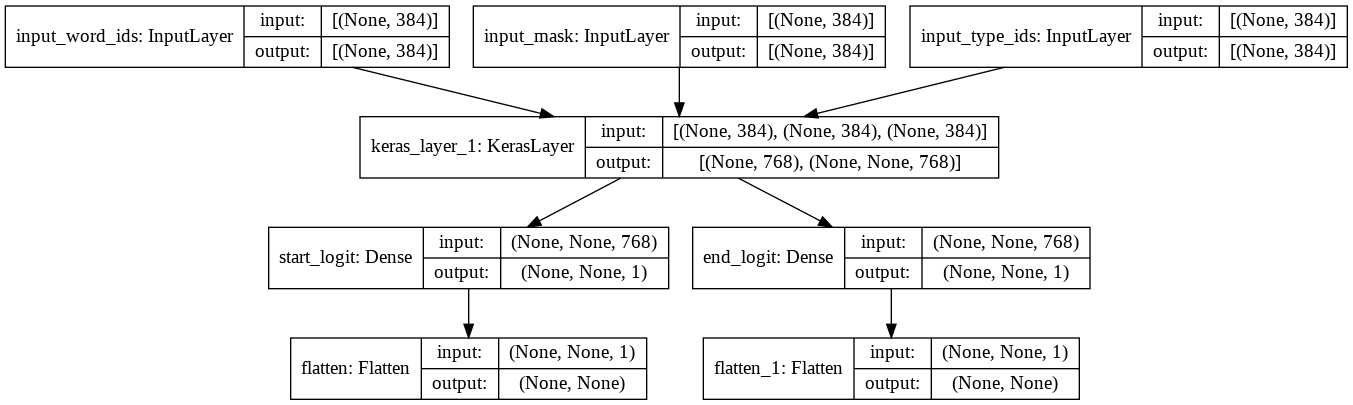

In [17]:
model.summary()
tf.keras.utils.plot_model(model, "./multi_input_and_output_model.png", show_shapes=True)

In [18]:
model.save_weights("./weights.h5")

#4.Evaluate the QA model

In [ ]:
model.load_weights("./weights.h5")

##F1 score

In [19]:
def normalize_text(text):
    # convert to lower case
    text = text.lower()
    # remove redundant whitespaces
    text = "".join(ch for ch in text if ch not in set(string.punctuation))
    # remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)
    text = " ".join(text.split())
    return text

In [20]:
def compute_f1(raw_test_data):
    test_squad_samples = create_squad_examples(raw_test_data)
    x_test, _ = create_inputs_targets(test_squad_samples)
    pred_start, pred_end = model.predict(x_test)

    test_examples_no_skip = [_ for _ in test_squad_samples if _.skip == False]
    
    f1_scores = []
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        # take the required Sample object with the ground-truth answers in it
        squad_eg = test_examples_no_skip[idx]
        # use offsets to get back the span of text corresponding to
        # our predicted first and last tokens
        offsets = squad_eg.context_token_to_char
        start = np.argmax(start)
        end = np.argmax(end)
        # if start index is larger than the length of tokens
        if start >= len(offsets):
            f1_scores.append(0)
            continue
        
        pred_char_start = offsets[start][0]
        if end < len(offsets):
            pred_char_end = offsets[end][1]
            pred_ans = squad_eg.context[pred_char_start:pred_char_end]
        else:
            pred_ans = squad_eg.context[pred_char_start:]
        
        normalized_pred_ans = normalize_text(pred_ans)
        pred_tokens = normalized_pred_ans.split()
        
        # if at least one of all_answers and pred_tokens is empty
        if not squad_eg.all_answers or len(pred_tokens) == 0:
            if not squad_eg.all_answers and len(pred_tokens) == 0:
                f1_scores.append(1)
            else:
                f1_scores.append(0)
            continue

        max_f1 = float('-inf')
        normalized_true_ans_lst = [normalize_text(_) for _ in squad_eg.all_answers]
        for normalized_true_ans in normalized_true_ans_lst:
            truth_tokens = normalized_true_ans.split()
            common_tokens = set(pred_tokens) & set(truth_tokens)
            # if there are no common tokens then f1 = 0
            if len(common_tokens) == 0:
                max_f1 = max(max_f1, 0)
            
            else:
                prec = len(common_tokens) / len(pred_tokens)
                rec = len(common_tokens) / len(truth_tokens)   
                max_f1 = max(max_f1, 2 * (prec * rec) / (prec + rec))
        
        f1_scores.append(max_f1)

    print(f"f1 score={np.mean(f1_scores):.2f}")
    return f1_scores

In [21]:
f1_scores = compute_f1(raw_eval_data)

f1 score=0.44


##Exact match

In [25]:
def exact_match_score(raw_test_data):
    test_squad_samples = create_squad_examples(raw_test_data)
    x_test, _ = create_inputs_targets(test_squad_samples)
    pred_start, pred_end = model.predict(x_test)

    test_examples_no_skip = [_ for _ in test_squad_samples if _.skip == False]
    
    count = 0

    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        # take the required Sample object with the ground-truth answers in it
        squad_eg = test_examples_no_skip[idx]
        # use offsets to get back the span of text corresponding to
        # our predicted first and last tokens
        offsets = squad_eg.context_token_to_char
        start = np.argmax(start)
        end = np.argmax(end)
        if start >= len(offsets):
            continue
        pred_char_start = offsets[start][0]
        if end < len(offsets):
            pred_char_end = offsets[end][1]
            pred_ans = squad_eg.context[pred_char_start:pred_char_end]
        else:
            pred_ans = squad_eg.context[pred_char_start:]
        normalized_pred_ans = normalize_text(pred_ans)

        # special case for all_answers is None or len(pred_ans) is empty
        if not squad_eg.all_answers or len(pred_ans) == 0:
            if not squad_eg.all_answers and len(pred_ans) == 0:
                count += 1
            continue 
        
        # clean the real answers
        normalized_true_ans_lst = [normalize_text(_) for _ in squad_eg.all_answers]
        # check if the predicted answer is in an array of the ground-truth answers
        if normalized_pred_ans in normalized_true_ans_lst:
            count += 1
    acc = count / len(x_test[0])
    print(f"exact match score={acc:.2f}")

In [26]:
exact_match_score(raw_eval_data)

exact match score=0.40


In [23]:
def exact_match_score_answers(raw_test_data):
    test_squad_samples = create_squad_examples(raw_test_data)
    test_squad_samples_answers = [sample for sample in test_squad_samples if sample.start_token_idx != -1]
    x_test, y_test = create_inputs_targets(test_squad_samples_answers)
    pred_start, pred_end = model.predict(x_test)

    test_examples_no_skip = [_ for _ in test_squad_samples if _.skip == False 
                             and _.start_token_idx != -1]
    
    count = 0

    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        # take the required Sample object with the ground-truth answers in it
        squad_eg = test_examples_no_skip[idx]
        # use offsets to get back the span of text corresponding to
        # our predicted first and last tokens
        offsets = squad_eg.context_token_to_char
        start = np.argmax(start)
        end = np.argmax(end)
        if start >= len(offsets):
            continue
        pred_char_start = offsets[start][0]
        if end < len(offsets):
            pred_char_end = offsets[end][1]
            pred_ans = squad_eg.context[pred_char_start:pred_char_end]
        else:
            pred_ans = squad_eg.context[pred_char_start:]
        normalized_pred_ans = normalize_text(pred_ans)

        # special case for all_answers is None or len(pred_ans) is empty
        if not squad_eg.all_answers or len(pred_ans) == 0:
            if not squad_eg.all_answers and len(pred_ans) == 0:
                count += 1
            continue 
        
        # clean the real answers
        normalized_true_ans_lst = [normalize_text(_) for _ in squad_eg.all_answers]
        # check if the predicted answer is in an array of the ground-truth answers
        if normalized_pred_ans in normalized_true_ans_lst:
            count += 1
    acc = count / len(x_test[0])
    print(f"exact match score={acc:.2f}")

In [24]:
exact_match_score_answers(raw_eval_data)

exact match score=0.76


In [27]:
def exact_match_score_no_answers(raw_test_data):
    test_squad_samples = create_squad_examples(raw_test_data)
    test_squad_samples_answers = [sample for sample in test_squad_samples if sample.start_token_idx == -1]
    x_test, y_test = create_inputs_targets(test_squad_samples_answers)
    pred_start, pred_end = model.predict(x_test)

    test_examples_no_skip = [_ for _ in test_squad_samples if _.skip == False 
                             and _.start_token_idx == -1]
    
    count = 0

    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        # take the required Sample object with the ground-truth answers in it
        squad_eg = test_examples_no_skip[idx]
        # use offsets to get back the span of text corresponding to
        # our predicted first and last tokens
        offsets = squad_eg.context_token_to_char
        start = np.argmax(start)
        end = np.argmax(end)
        if start >= len(offsets):
            continue
        pred_char_start = offsets[start][0]
        if end < len(offsets):
            pred_char_end = offsets[end][1]
            pred_ans = squad_eg.context[pred_char_start:pred_char_end]
        else:
            pred_ans = squad_eg.context[pred_char_start:]
        normalized_pred_ans = normalize_text(pred_ans)

        # special case for all_answers is None or len(pred_ans) is empty
        if not squad_eg.all_answers or len(pred_ans) == 0:
            if not squad_eg.all_answers and len(pred_ans) == 0:
                count += 1
            continue 
        
        # clean the real answers
        normalized_true_ans_lst = [normalize_text(_) for _ in squad_eg.all_answers]
        # check if the predicted answer is in an array of the ground-truth answers
        if normalized_pred_ans in normalized_true_ans_lst:
            count += 1
    acc = count / len(x_test[0])
    print(f"exact match score={acc:.2f}")

In [28]:
exact_match_score_no_answers(raw_eval_data)

exact match score=0.04


##Examples

In [ ]:
def evaluate_qa_model(raw_test_data, verbose=True):
    test_samples = create_squad_examples(raw_test_data)
    x_test, _ = create_inputs_targets(test_samples)
    pred_start, pred_end = model.predict(x_test)
    pred_ans_lst = []
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        test_sample = test_samples[idx]
        offsets = test_sample.context_token_to_char
        start = np.argmax(start)
        end = np.argmax(end)
        pred_ans = None
        if start >= len(offsets):
            continue
        pred_char_start = offsets[start][0]
        if end < len(offsets):
            pred_char_end = offsets[end][1]
            pred_ans = test_sample.context[pred_char_start:pred_char_end]
        else:
            pred_ans = test_sample.context[pred_char_start:]
        
        pred_ans_lst.append(pred_ans)

        if verbose: 
            print("Q: " + test_sample.question)
            print("A: " + pred_ans)
    
    return pred_ans_lst

In [ ]:
data = {"data":
    [
        {"title": "Clinical note",
         "paragraphs": [
             {
                 "context": "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, "
                            "and valvular insufficiency. The patient complains of shortness of breath, which is worsening. "
                            "The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large "
                            "pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain "
                            "and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment."
                            "During the hospitalization, the patient complains of shortness of breath, which is worsening."
                            "The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large "
                            "pleural effusion. This consultation is for further evaluation in this regard. As per the patient, "
                            "she is an 86-year-old female, has limited activity level. She has been having shortness of breath "
                            "for many years. She also was told that she has a heart murmur, which was not followed through "
                            "on a regular basis.",
                 "qas": [
                     {"question": "How old is the patient?",
                      "id": "Q1"
                      },
                     {"question": "Does the patient have any complaints?",
                      "id": "Q2"
                      },
                     {"question":"What is the reason for this consultation?",
                      "id": "Q3"
                      },
                     {"question": "What does her echocardiogram show?",
                      "id": "Q4"
                      },
                     {"question": "What other symptoms does the patient have?",
                      "id": "Q5"
                      },
                     {"question": "What's the gender of this patient?",
                      "id": "Q6"
                      }
                 ]}]}]}

pred_ans_lst = evaluate_qa_model(data)

Q: How old is the patient?
A: 86
Q: Does the patient have any complaints?
A: shortness of breath
Q: What is the reason for this consultation?
A: further evaluation
Q: What does her echocardiogram show?
A: severe mitral regurgitation and also large pleural effusion
Q: What other symptoms does the patient have?
A: colitis
Q: What's the gender of this patient?
A: an 86-year-old female


In [ ]:
data = {"data":
    [
        {"title": "Project Apollo",
         "paragraphs": [
             {
                 "context": "The Apollo program, also known as Project Apollo, was the third United States human "
                            "spaceflight program carried out by the National Aeronautics and Space Administration ("
                            "NASA), which accomplished landing the first humans on the Moon from 1969 to 1972. First "
                            "conceived during Dwight D. Eisenhower's administration as a three-man spacecraft to "
                            "follow the one-man Project Mercury which put the first Americans in space, Apollo was "
                            "later dedicated to President John F. Kennedy's national goal of landing a man on the "
                            "Moon and returning him safely to the Earth by the end of the 1960s, which he proposed in "
                            "a May 25, 1961, address to Congress. Project Mercury was followed by the two-man Project "
                            "Gemini. The first manned flight of Apollo was in 1968. Apollo ran from 1961 to 1972, "
                            "and was supported by the two man Gemini program which ran concurrently with it from 1962 "
                            "to 1966. Gemini missions developed some of the space travel techniques that were "
                            "necessary for the success of the Apollo missions. Apollo used Saturn family rockets as "
                            "launch vehicles. Apollo/Saturn vehicles were also used for an Apollo Applications "
                            "Program, which consisted of Skylab, a space station that supported three manned missions "
                            "in 1973-74, and the Apollo-Soyuz Test Project, a joint Earth orbit mission with the "
                            "Soviet Union in 1975.",
                 "qas": [
                     {"question": "What project put the first Americans into space?",
                      "id": "Q1"
                      },
                     {"question": "What program was created to carry out these projects and missions?",
                      "id": "Q2"
                      },
                     {"question": "What year did the first manned Apollo flight occur?",
                      "id": "Q3"
                      },
                     {"question": "What President is credited with the original notion of putting Americans in space?",
                      "id": "Q4"
                      },
                     {"question": "Who did the U.S. collaborate with on an Earth orbit mission in 1975?",
                      "id": "Q5"
                      },
                     {"question": "How long did Project Apollo run?",
                      "id": "Q6"
                      },
                     {"question": "What program helped develop space travel techniques that Project Apollo used?",
                      "id": "Q7"
                      },
                     {"question": "What space station supported three manned missions in 1973-1974?",
                      "id": "Q8"
                      }
                 ]}]}]}


pred_ans_lst = evaluate_qa_model(data)

Q: What project put the first Americans into space?
A: Project Mercury
Q: What program was created to carry out these projects and missions?
A: The Apollo program
Q: What year did the first manned Apollo flight occur?
A: 1968
Q: What President is credited with the original notion of putting Americans in space?
A: Dwight D. Eisenhower
Q: Who did the U.S. collaborate with on an Earth orbit mission in 1975?
A: Soviet Union
Q: How long did Project Apollo run?
A: 1961 to 1972
Q: What program helped develop space travel techniques that Project Apollo used?
A: Gemini missions
Q: What space station supported three manned missions in 1973-1974?
A: Skylab


In [ ]:
data = {"data":
    [
        {"title": "Project Apollo",
         "paragraphs": [
             {
                 "context": "The word pharmacy is derived from its root word pharma which was a term used since "
                            "the 15th–17th centuries. However, the original Greek roots from pharmakos imply sorcery "
                            "or even poison. In addition to pharma responsibilities, the pharma offered general medical "
                            "advice and a range of services that are now performed solely by other specialist practitioners, "
                            "such as surgery and midwifery. The pharma (as it was referred to) often operated through a "
                            "retail shop which, in addition to ingredients for medicines, sold tobacco and patent medicines. "
                            "Often the place that did this was called an apothecary and several languages have this as the "
                            "dominant term, though their practices are more akin to a modern pharmacy, in English the term "
                            "apothecary would today be seen as outdated or only approproriate if herbal remedies were on offer "
                            "to a large extent. The pharmas also used many other herbs not listed. The Greek word Pharmakeia "
                            "(Greek: φαρμακεία) derives from pharmakon (φάρμακον), meaning 'drug', 'medicine' (or 'poison').",
                 "qas": [
                     {"question": "What word is the word pharmacy taken from??",
                      "id": "Q1"
                      },
                    {"question": "When is the word pharmacy derived??",
                      "id": "Q2"
                      },
                    {"question": "How did pharma operate??",
                      "id": "Q3"
                      }
                 ]}]}]}


pred_ans_lst = evaluate_qa_model(data)

Q: What word is the word pharmacy taken from??
A: pharma
Q: When is the word pharmacy derived??
A: 15th–17th centuries
Q: How did pharma operate??
A: through a retail shop


#5.Deploy the model on Django